# Import Package

In [102]:
SEED = 42

# 基本套件
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Categorical Data Transforming
import category_encoders as ce
from sklearn.impute import KNNImputer

# Change Scaler
from sklearn.preprocessing import StandardScaler

# 資料集切割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold

# 特徵篩選
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# 使用模型
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import catboost as cb
# import tensorflow as tf


# 資料視覺化
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# 最佳化參數
import optuna

os.getcwd()

'C:\\Users\\USER\\Desktop\\Kev\\碩一\\人工智慧\\HW2'

# Read data

In [103]:
df = pd.read_csv(r'./train.csv')
print('view the data shape', df.shape)
df.head()

view the data shape (10108, 9)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,2008/9/30,Female,Service,No,2,3.0,3.8,0.16
1,1,2008/11/30,Male,Service,Yes,1,2.0,5.0,0.36
2,2,2008/3/10,Female,Product,Yes,2,NaN,5.8,0.49
3,3,2008/11/3,Male,Service,Yes,1,1.0,2.6,0.20
4,4,2008/7/24,Female,Service,No,3,7.0,6.9,0.52


In [104]:
# elliminate traget not na
df = df[df['Burn Rate'].notna()]

In [105]:
df = df[df.columns[1:]]
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

C:\Users\USER\AppData\Local\Temp\ipykernel_16600\58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<AxesSubplot: >

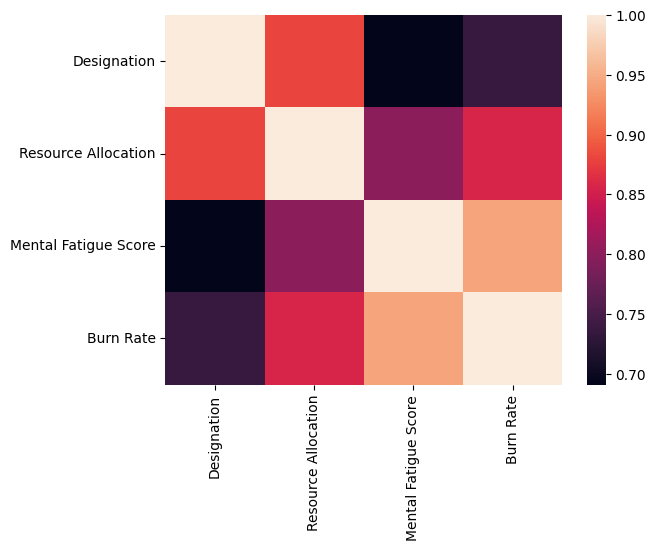

In [106]:
sns.heatmap(df.corr())

In [107]:
df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,9624.000000,9041.000000,8738.000000,9624.000000
mean,2.183292,4.500055,5.731231,0.452351
std,1.141031,2.051501,1.921508,0.198787
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.320000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


# Data Preprocessing

## Transfer Time related Data

In [108]:
def transfer_date(date):
    date_format = "%Y/%m/%d"
    a = datetime.strptime('2022/10/10', date_format)
    b = datetime.strptime(date, date_format)
    delta = a - b
    return delta.days

In [109]:
X['Date of Joining'] = X['Date of Joining'].apply(lambda x : transfer_date(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_16600\1446608504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date of Joining'] = X['Date of Joining'].apply(lambda x : transfer_date(x))


## Categorical Data Transforming -  Target Encoder

In [110]:
## 原類別型
ce_leave = ce.GLMMEncoder(cols = ['Gender','Company Type','WFH Setup Available'],binomial_target = False,handle_unknown='value')
ce_leave.fit(X, y)     
X = ce_leave.transform(X)

## Normalize Data

In [111]:
# Normalization
Normalize_scaler = StandardScaler()
X = pd.DataFrame(Normalize_scaler.fit_transform(X), columns=X.columns, index=X.index)

## Fill Missing Value - KNN Imputer

In [112]:
X.isna().sum()

Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     583
Mental Fatigue Score    886
dtype: int64

In [113]:
# TODO
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X),columns = X.columns)

In [114]:
X.isna().sum()

Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64

In [115]:
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)

# EDA

<AxesSubplot: >

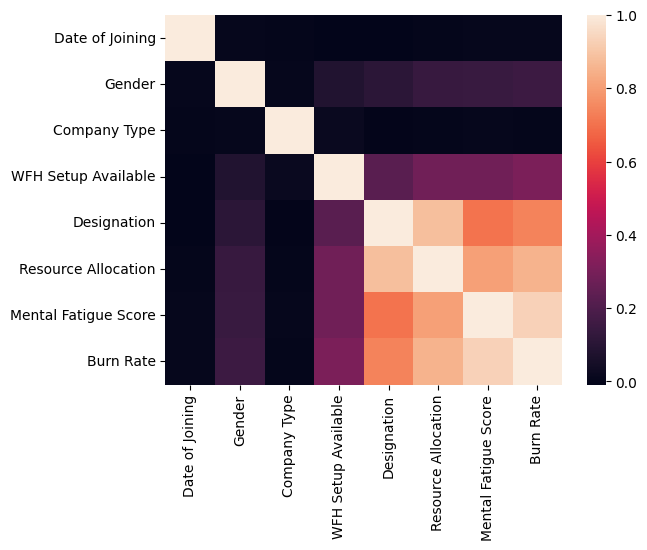

In [116]:
df = pd.concat([X,y],axis=1)
sns.heatmap(df.corr())

# Feature Selection

## Hypterparameter tuning - Optuna

In [117]:
#optuna to set the hyperparameter of XGBoost
def objective_xgb(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, 100),
        'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
        'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0)
    }
    model = xgb.XGBRegressor(**param,tree_method='gpu_hist',random_state=SEED).fit(X_train,y_train['Burn Rate'])
    y_pred = model.predict(X_valid)
    pred_list = y_pred.tolist()
    act_list = y_valid['Burn Rate'].tolist()

    error_list = []   
    for i in range(0, len(y_pred)):
        error_list.append(abs(round(act_list[i] - pred_list[i], 4)))
    abs_error_list_r4 =  [abs(ele) for ele in error_list]
    
    return sum(abs_error_list_r4)/len(abs_error_list_r4)

In [118]:
def objective_cat(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    reg = cb.CatBoostRegressor(**param)
    reg.fit(X_train, y_train['Burn Rate'], verbose=0, early_stopping_rounds=100)
    y_pred = reg.predict(X_valid)
    pred_list = y_pred.tolist()
    act_list = y_valid['Burn Rate'].tolist()

    error_list = []   
    for i in range(0, len(y_pred)):
        error_list.append(abs(round(act_list[i] - pred_list[i], 4)))
    abs_error_list_r4 =  [abs(ele) for ele in error_list]
    
    return sum(abs_error_list_r4)/len(abs_error_list_r4)

In [119]:
# 分成不同盒子 - 分層抽樣用
def get_box(df):
    Y1_list = []
    for Y1 in df['Burn Rate']: 
        if (Y1 > np.percentile(df['Burn Rate'], 80)):
            Y1_list.append('3')
        elif (Y1 < np.percentile(df['Burn Rate'], 20)):
            Y1_list.append('2')
        else:
            Y1_list.append('1')
    df['box'] = Y1_list
    return df

In [120]:
# 分層抽樣因子
df = get_box(df)

X = df[df.columns[:-2]]
y = df[df.columns[-2:]]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y['box'])


X_train.reset_index(drop=True,inplace=True)
X_valid.reset_index(drop=True,inplace=True) 
y_train.reset_index(drop=True,inplace=True) 
y_valid.reset_index(drop=True,inplace=True)


In [121]:
# # optuna
# study_xgb = optuna.create_study(direction="minimize")
# study_xgb.optimize(objective_xgb, n_trials=100, n_jobs=4)

In [122]:
# optuna
study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=100)

[I 2022-10-13 18:18:35,978] A new study created in memory with name: no-name-c39afdbc-f69c-43e0-8b13-8e22b5070e5f
C:\Users\USER\AppData\Local\Temp\ipykernel_16600\150158002.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
C:\Users\USER\AppData\Local\Temp\ipykernel_16600\150158002.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items in

[I 2022-10-13 18:18:47,075] Trial 17 finished with value: 0.15210696103896132 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.0003731842209774073, 'l2_leaf_reg': 0.568951630768538, 'colsample_bylevel': 0.08229659778285728, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 13, 'one_hot_max_size': 8}. Best is trial 12 with value: 0.04815854545454562.
[I 2022-10-13 18:18:48,057] Trial 18 finished with value: 0.16251163636363675 and parameters: {'loss_function': 'MAE', 'learning_rate': 1.2345010418224009e-05, 'l2_leaf_reg': 0.256172940254729, 'colsample_bylevel': 0.0998620482441392, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 17, 'one_hot_max_size': 4, 'subsample': 0.1734248897532799}. Best is trial 12 with value: 0.04815854545454562.
[I 2022-10-13 18:18:48,719] Trial 19 finished with value: 0.05220774025974027 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.8367345420019114, 'l2_lea

[I 2022-10-13 18:18:56,284] Trial 36 finished with value: 0.048241506493506565 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.9929798682235814, 'l2_leaf_reg': 0.06986490597731718, 'colsample_bylevel': 0.07782108827191042, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 18, 'one_hot_max_size': 12}. Best is trial 31 with value: 0.04811698701298712.
[I 2022-10-13 18:18:56,805] Trial 37 finished with value: 0.049016935064935103 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.46579568580195035, 'l2_leaf_reg': 0.12975082037043334, 'colsample_bylevel': 0.08723685675707879, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 17}. Best is trial 31 with value: 0.04811698701298712.
[I 2022-10-13 18:18:57,300] Trial 38 finished with value: 0.13059942857142853 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.001221394569705035, 'l2_leaf_reg': 0.07415077186897977, 'colsample_

[I 2022-10-13 18:19:04,914] Trial 56 finished with value: 0.05131787012987005 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.051066160572234814, 'l2_leaf_reg': 0.20571449915341133, 'colsample_bylevel': 0.0995155106509156, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 7}. Best is trial 53 with value: 0.04730057142857153.
[I 2022-10-13 18:19:05,336] Trial 57 finished with value: 0.049533610389610426 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.16014827657184608, 'l2_leaf_reg': 0.4009569628411707, 'colsample_bylevel': 0.09779595543477679, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 9, 'one_hot_max_size': 8}. Best is trial 53 with value: 0.04730057142857153.
[I 2022-10-13 18:19:06,178] Trial 58 finished with value: 0.09553122077922101 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.003389973704879792, 'l2_leaf_reg': 0.146364771344344, 'colsample_byle

[I 2022-10-13 18:19:15,254] Trial 77 finished with value: 0.1473653506493507 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.0005270811613697087, 'l2_leaf_reg': 0.4597111546578593, 'colsample_bylevel': 0.09802836425965668, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 3}. Best is trial 53 with value: 0.04730057142857153.
[I 2022-10-13 18:19:16,021] Trial 78 finished with value: 0.05072945454545441 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.42779692936944597, 'l2_leaf_reg': 0.23783849719619934, 'colsample_bylevel': 0.08616080594611876, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 4, 'one_hot_max_size': 6}. Best is trial 53 with value: 0.04730057142857153.
[I 2022-10-13 18:19:16,437] Trial 79 finished with value: 0.04982025974025972 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.1167772713940882, 'l2_leaf_reg': 0.5160803628203671, 'colsample_byl

[I 2022-10-13 18:19:24,833] Trial 97 finished with value: 0.04839709090909093 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.3853969038250725, 'l2_leaf_reg': 0.18465159409611584, 'colsample_bylevel': 0.08525733867646204, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 14}. Best is trial 85 with value: 0.046695116883116734.
[I 2022-10-13 18:19:25,195] Trial 98 finished with value: 0.0554824415584416 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.5692692142182575, 'l2_leaf_reg': 0.15568032288506384, 'colsample_bylevel': 0.011144038851967061, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 6, 'one_hot_max_size': 10}. Best is trial 85 with value: 0.046695116883116734.
[I 2022-10-13 18:19:25,622] Trial 99 finished with value: 0.048927584415584466 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.27602048469545903, 'l2_leaf_reg': 0.23240701132101377, 'colsample_

# Sequential Feature Selection

In [125]:
# begin SFS
model_cat = cb.CatBoostRegressor(**study_cat.best_params,random_state=SEED)

sfs1_CAT = SFS(model_cat, 
           k_features= int(round(X.shape[1],0)), 
           floating=True,# 可以改false，如果跑太久
           forward=True,  
           verbose=2,
           cv=5,
           n_jobs=4)



sfs1_CAT = sfs1_CAT.fit(X, y['Burn Rate'])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   7 | elapsed:    3.8s remaining:    2.8s
[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:    6.3s finished

[2022-10-13 18:20:44] Features: 1/7 -- score: 0.868800699227044[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    5.2s finished

[2022-10-13 18:20:50] Features: 2/7 -- score: 0.8962111369189278[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.6s finished

[2022-10-13 18:20:59] Features: 3/7 -- score: 0.8982324039077947[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent 

0:	learn: 0.1983682	total: 398us	remaining: 398ms
1:	learn: 0.1983682	total: 909us	remaining: 454ms
2:	learn: 0.1983678	total: 1.35ms	remaining: 449ms
3:	learn: 0.1893396	total: 1.81ms	remaining: 452ms
4:	learn: 0.1893396	total: 2.15ms	remaining: 427ms
5:	learn: 0.1893396	total: 2.47ms	remaining: 409ms
6:	learn: 0.1893395	total: 2.93ms	remaining: 416ms
7:	learn: 0.1893395	total: 3.25ms	remaining: 403ms
8:	learn: 0.1476336	total: 3.66ms	remaining: 403ms
9:	learn: 0.1476336	total: 4.03ms	remaining: 399ms
10:	learn: 0.1321427	total: 4.52ms	remaining: 407ms
11:	learn: 0.1294273	total: 5.01ms	remaining: 412ms
12:	learn: 0.1294273	total: 5.37ms	remaining: 408ms
13:	learn: 0.1175781	total: 5.99ms	remaining: 422ms
14:	learn: 0.1175781	total: 6.34ms	remaining: 417ms
15:	learn: 0.1149162	total: 6.77ms	remaining: 417ms
16:	learn: 0.1147399	total: 7.22ms	remaining: 418ms
17:	learn: 0.1051835	total: 7.85ms	remaining: 428ms
18:	learn: 0.1051833	total: 8.26ms	remaining: 426ms
19:	learn: 0.1051833	tot

416:	learn: 0.0601260	total: 184ms	remaining: 257ms
417:	learn: 0.0601259	total: 184ms	remaining: 257ms
418:	learn: 0.0601254	total: 185ms	remaining: 256ms
419:	learn: 0.0601254	total: 185ms	remaining: 256ms
420:	learn: 0.0601254	total: 185ms	remaining: 255ms
421:	learn: 0.0601250	total: 186ms	remaining: 255ms
422:	learn: 0.0601243	total: 186ms	remaining: 254ms
423:	learn: 0.0601243	total: 187ms	remaining: 254ms
424:	learn: 0.0601243	total: 187ms	remaining: 253ms
425:	learn: 0.0601243	total: 187ms	remaining: 253ms
426:	learn: 0.0601143	total: 188ms	remaining: 252ms
427:	learn: 0.0601101	total: 189ms	remaining: 252ms
428:	learn: 0.0600759	total: 189ms	remaining: 252ms
429:	learn: 0.0600759	total: 190ms	remaining: 251ms
430:	learn: 0.0600759	total: 190ms	remaining: 251ms
431:	learn: 0.0600734	total: 190ms	remaining: 250ms
432:	learn: 0.0600711	total: 191ms	remaining: 250ms
433:	learn: 0.0600380	total: 192ms	remaining: 250ms
434:	learn: 0.0600380	total: 192ms	remaining: 249ms
435:	learn: 

845:	learn: 0.0578640	total: 373ms	remaining: 67.9ms
846:	learn: 0.0578640	total: 373ms	remaining: 67.5ms
847:	learn: 0.0578625	total: 374ms	remaining: 67ms
848:	learn: 0.0578597	total: 375ms	remaining: 66.6ms
849:	learn: 0.0578597	total: 375ms	remaining: 66.2ms
850:	learn: 0.0578597	total: 376ms	remaining: 65.8ms
851:	learn: 0.0578597	total: 376ms	remaining: 65.3ms
852:	learn: 0.0578597	total: 376ms	remaining: 64.9ms
853:	learn: 0.0578236	total: 377ms	remaining: 64.5ms
854:	learn: 0.0578236	total: 377ms	remaining: 64ms
855:	learn: 0.0578228	total: 378ms	remaining: 63.6ms
856:	learn: 0.0578228	total: 378ms	remaining: 63.1ms
857:	learn: 0.0577907	total: 379ms	remaining: 62.7ms
858:	learn: 0.0577852	total: 379ms	remaining: 62.3ms
859:	learn: 0.0577852	total: 380ms	remaining: 61.8ms
860:	learn: 0.0577517	total: 380ms	remaining: 61.4ms
861:	learn: 0.0577408	total: 381ms	remaining: 61ms
862:	learn: 0.0577395	total: 381ms	remaining: 60.6ms
863:	learn: 0.0577395	total: 382ms	remaining: 60.1ms

228:	learn: 0.0609996	total: 103ms	remaining: 346ms
229:	learn: 0.0609996	total: 103ms	remaining: 345ms
230:	learn: 0.0609996	total: 103ms	remaining: 344ms
231:	learn: 0.0609995	total: 104ms	remaining: 344ms
232:	learn: 0.0609995	total: 104ms	remaining: 343ms
233:	learn: 0.0609995	total: 105ms	remaining: 342ms
234:	learn: 0.0609995	total: 105ms	remaining: 342ms
235:	learn: 0.0609817	total: 105ms	remaining: 341ms
236:	learn: 0.0609564	total: 106ms	remaining: 341ms
237:	learn: 0.0609564	total: 106ms	remaining: 340ms
238:	learn: 0.0609564	total: 107ms	remaining: 340ms
239:	learn: 0.0609506	total: 107ms	remaining: 339ms
240:	learn: 0.0609463	total: 108ms	remaining: 339ms
241:	learn: 0.0609428	total: 108ms	remaining: 338ms
242:	learn: 0.0609052	total: 109ms	remaining: 338ms
243:	learn: 0.0609052	total: 109ms	remaining: 338ms
244:	learn: 0.0609052	total: 109ms	remaining: 337ms
245:	learn: 0.0609052	total: 110ms	remaining: 336ms
246:	learn: 0.0609052	total: 110ms	remaining: 335ms
247:	learn: 

671:	learn: 0.0581643	total: 294ms	remaining: 143ms
672:	learn: 0.0581643	total: 294ms	remaining: 143ms
673:	learn: 0.0581643	total: 294ms	remaining: 142ms
674:	learn: 0.0581557	total: 295ms	remaining: 142ms
675:	learn: 0.0581544	total: 295ms	remaining: 141ms
676:	learn: 0.0581544	total: 296ms	remaining: 141ms
677:	learn: 0.0581544	total: 296ms	remaining: 141ms
678:	learn: 0.0581544	total: 297ms	remaining: 140ms
679:	learn: 0.0581516	total: 297ms	remaining: 140ms
680:	learn: 0.0581516	total: 297ms	remaining: 139ms
681:	learn: 0.0581501	total: 298ms	remaining: 139ms
682:	learn: 0.0581501	total: 298ms	remaining: 138ms
683:	learn: 0.0581492	total: 299ms	remaining: 138ms
684:	learn: 0.0581467	total: 299ms	remaining: 138ms
685:	learn: 0.0581467	total: 299ms	remaining: 137ms
686:	learn: 0.0581452	total: 300ms	remaining: 137ms
687:	learn: 0.0580751	total: 301ms	remaining: 136ms
688:	learn: 0.0580751	total: 301ms	remaining: 136ms
689:	learn: 0.0580751	total: 301ms	remaining: 135ms
690:	learn: 

41:	learn: 0.0690779	total: 19ms	remaining: 433ms
42:	learn: 0.0690779	total: 19.5ms	remaining: 433ms
43:	learn: 0.0689605	total: 20.1ms	remaining: 436ms
44:	learn: 0.0684770	total: 20.6ms	remaining: 437ms
45:	learn: 0.0681696	total: 21.1ms	remaining: 437ms
46:	learn: 0.0681696	total: 21.5ms	remaining: 435ms
47:	learn: 0.0680361	total: 21.9ms	remaining: 434ms
48:	learn: 0.0680360	total: 22.3ms	remaining: 433ms
49:	learn: 0.0679062	total: 22.7ms	remaining: 432ms
50:	learn: 0.0665874	total: 23.3ms	remaining: 433ms
51:	learn: 0.0665435	total: 23.9ms	remaining: 436ms
52:	learn: 0.0665237	total: 24.4ms	remaining: 436ms
53:	learn: 0.0665237	total: 24.8ms	remaining: 434ms
54:	learn: 0.0663115	total: 25.4ms	remaining: 437ms
55:	learn: 0.0661583	total: 26ms	remaining: 438ms
56:	learn: 0.0650024	total: 27ms	remaining: 446ms
57:	learn: 0.0650024	total: 27.3ms	remaining: 444ms
58:	learn: 0.0648351	total: 28.2ms	remaining: 449ms
59:	learn: 0.0648351	total: 28.6ms	remaining: 447ms
60:	learn: 0.06451

468:	learn: 0.0587011	total: 210ms	remaining: 237ms
469:	learn: 0.0587011	total: 210ms	remaining: 237ms
470:	learn: 0.0587011	total: 211ms	remaining: 237ms
471:	learn: 0.0587011	total: 211ms	remaining: 236ms
472:	learn: 0.0586990	total: 212ms	remaining: 236ms
473:	learn: 0.0586615	total: 212ms	remaining: 235ms
474:	learn: 0.0586555	total: 213ms	remaining: 235ms
475:	learn: 0.0586555	total: 213ms	remaining: 235ms
476:	learn: 0.0585326	total: 214ms	remaining: 235ms
477:	learn: 0.0585239	total: 215ms	remaining: 235ms
478:	learn: 0.0585239	total: 215ms	remaining: 234ms
479:	learn: 0.0585139	total: 216ms	remaining: 234ms
480:	learn: 0.0585137	total: 216ms	remaining: 233ms
481:	learn: 0.0585137	total: 216ms	remaining: 233ms
482:	learn: 0.0584898	total: 217ms	remaining: 232ms
483:	learn: 0.0584897	total: 218ms	remaining: 232ms
484:	learn: 0.0584897	total: 218ms	remaining: 231ms
485:	learn: 0.0584897	total: 218ms	remaining: 231ms
486:	learn: 0.0584896	total: 219ms	remaining: 230ms
487:	learn: 

903:	learn: 0.0568520	total: 402ms	remaining: 42.7ms
904:	learn: 0.0568520	total: 402ms	remaining: 42.2ms
905:	learn: 0.0568520	total: 403ms	remaining: 41.8ms
906:	learn: 0.0568520	total: 403ms	remaining: 41.3ms
907:	learn: 0.0568461	total: 404ms	remaining: 40.9ms
908:	learn: 0.0568446	total: 404ms	remaining: 40.5ms
909:	learn: 0.0568446	total: 405ms	remaining: 40ms
910:	learn: 0.0568446	total: 405ms	remaining: 39.6ms
911:	learn: 0.0568446	total: 405ms	remaining: 39.1ms
912:	learn: 0.0568446	total: 406ms	remaining: 38.7ms
913:	learn: 0.0568262	total: 406ms	remaining: 38.2ms
914:	learn: 0.0568262	total: 407ms	remaining: 37.8ms
915:	learn: 0.0568262	total: 407ms	remaining: 37.3ms
916:	learn: 0.0568262	total: 408ms	remaining: 36.9ms
917:	learn: 0.0567828	total: 408ms	remaining: 36.5ms
918:	learn: 0.0567818	total: 409ms	remaining: 36ms
919:	learn: 0.0567818	total: 409ms	remaining: 35.6ms
920:	learn: 0.0567818	total: 410ms	remaining: 35.1ms
921:	learn: 0.0567808	total: 410ms	remaining: 34.7

278:	learn: 0.0604059	total: 126ms	remaining: 325ms
279:	learn: 0.0604029	total: 126ms	remaining: 325ms
280:	learn: 0.0604015	total: 127ms	remaining: 325ms
281:	learn: 0.0604015	total: 127ms	remaining: 324ms
282:	learn: 0.0603958	total: 128ms	remaining: 324ms
283:	learn: 0.0603681	total: 129ms	remaining: 324ms
284:	learn: 0.0603681	total: 129ms	remaining: 323ms
285:	learn: 0.0603681	total: 129ms	remaining: 323ms
286:	learn: 0.0603672	total: 130ms	remaining: 323ms
287:	learn: 0.0603672	total: 130ms	remaining: 322ms
288:	learn: 0.0603672	total: 131ms	remaining: 321ms
289:	learn: 0.0603672	total: 131ms	remaining: 320ms
290:	learn: 0.0602566	total: 132ms	remaining: 321ms
291:	learn: 0.0602566	total: 132ms	remaining: 320ms
292:	learn: 0.0601261	total: 133ms	remaining: 321ms
293:	learn: 0.0601160	total: 133ms	remaining: 321ms
294:	learn: 0.0601160	total: 134ms	remaining: 320ms
295:	learn: 0.0601160	total: 134ms	remaining: 319ms
296:	learn: 0.0601140	total: 135ms	remaining: 319ms
297:	learn: 

712:	learn: 0.0579839	total: 317ms	remaining: 128ms
713:	learn: 0.0579839	total: 317ms	remaining: 127ms
714:	learn: 0.0579838	total: 318ms	remaining: 127ms
715:	learn: 0.0579838	total: 318ms	remaining: 126ms
716:	learn: 0.0579838	total: 319ms	remaining: 126ms
717:	learn: 0.0579838	total: 319ms	remaining: 125ms
718:	learn: 0.0579838	total: 319ms	remaining: 125ms
719:	learn: 0.0579838	total: 320ms	remaining: 124ms
720:	learn: 0.0579838	total: 320ms	remaining: 124ms
721:	learn: 0.0578816	total: 321ms	remaining: 124ms
722:	learn: 0.0578816	total: 321ms	remaining: 123ms
723:	learn: 0.0578816	total: 322ms	remaining: 123ms
724:	learn: 0.0578709	total: 322ms	remaining: 122ms
725:	learn: 0.0578708	total: 323ms	remaining: 122ms
726:	learn: 0.0578708	total: 323ms	remaining: 121ms
727:	learn: 0.0578708	total: 323ms	remaining: 121ms
728:	learn: 0.0578206	total: 324ms	remaining: 121ms
729:	learn: 0.0578190	total: 325ms	remaining: 120ms
730:	learn: 0.0578187	total: 325ms	remaining: 120ms
731:	learn: 

69:	learn: 0.0647962	total: 31.3ms	remaining: 416ms
70:	learn: 0.0646199	total: 32ms	remaining: 419ms
71:	learn: 0.0646199	total: 32.4ms	remaining: 417ms
72:	learn: 0.0644284	total: 32.9ms	remaining: 417ms
73:	learn: 0.0643631	total: 33.5ms	remaining: 419ms
74:	learn: 0.0643628	total: 33.9ms	remaining: 418ms
75:	learn: 0.0643628	total: 34.3ms	remaining: 417ms
76:	learn: 0.0643628	total: 34.6ms	remaining: 415ms
77:	learn: 0.0643354	total: 35.1ms	remaining: 415ms
78:	learn: 0.0643354	total: 35.4ms	remaining: 413ms
79:	learn: 0.0643279	total: 35.8ms	remaining: 412ms
80:	learn: 0.0643253	total: 36.3ms	remaining: 412ms
81:	learn: 0.0640560	total: 36.9ms	remaining: 413ms
82:	learn: 0.0640473	total: 37.3ms	remaining: 412ms
83:	learn: 0.0640473	total: 37.7ms	remaining: 411ms
84:	learn: 0.0640302	total: 38.1ms	remaining: 410ms
85:	learn: 0.0636756	total: 38.9ms	remaining: 413ms
86:	learn: 0.0636756	total: 39.3ms	remaining: 412ms
87:	learn: 0.0636756	total: 39.6ms	remaining: 410ms
88:	learn: 0.0

504:	learn: 0.0588595	total: 222ms	remaining: 218ms
505:	learn: 0.0587729	total: 223ms	remaining: 218ms
506:	learn: 0.0587729	total: 223ms	remaining: 217ms
507:	learn: 0.0587729	total: 224ms	remaining: 217ms
508:	learn: 0.0587711	total: 224ms	remaining: 216ms
509:	learn: 0.0587711	total: 224ms	remaining: 216ms
510:	learn: 0.0587687	total: 225ms	remaining: 215ms
511:	learn: 0.0587687	total: 225ms	remaining: 215ms
512:	learn: 0.0587136	total: 226ms	remaining: 215ms
513:	learn: 0.0587127	total: 226ms	remaining: 214ms
514:	learn: 0.0587127	total: 227ms	remaining: 214ms
515:	learn: 0.0587127	total: 227ms	remaining: 213ms
516:	learn: 0.0587117	total: 227ms	remaining: 213ms
517:	learn: 0.0586530	total: 228ms	remaining: 212ms
518:	learn: 0.0586530	total: 229ms	remaining: 212ms
519:	learn: 0.0586530	total: 229ms	remaining: 211ms
520:	learn: 0.0586530	total: 229ms	remaining: 211ms
521:	learn: 0.0586530	total: 230ms	remaining: 210ms
522:	learn: 0.0586472	total: 230ms	remaining: 210ms
523:	learn: 

903:	learn: 0.0571808	total: 414ms	remaining: 44ms
904:	learn: 0.0571808	total: 415ms	remaining: 43.5ms
905:	learn: 0.0571793	total: 415ms	remaining: 43.1ms
906:	learn: 0.0571793	total: 416ms	remaining: 42.6ms
907:	learn: 0.0571793	total: 416ms	remaining: 42.1ms
908:	learn: 0.0571683	total: 417ms	remaining: 41.7ms
909:	learn: 0.0571683	total: 417ms	remaining: 41.2ms
910:	learn: 0.0571683	total: 417ms	remaining: 40.8ms
911:	learn: 0.0571683	total: 418ms	remaining: 40.3ms
912:	learn: 0.0571683	total: 418ms	remaining: 39.8ms
913:	learn: 0.0571588	total: 419ms	remaining: 39.4ms
914:	learn: 0.0571564	total: 419ms	remaining: 38.9ms
915:	learn: 0.0571564	total: 420ms	remaining: 38.5ms
916:	learn: 0.0571564	total: 420ms	remaining: 38ms
917:	learn: 0.0571564	total: 420ms	remaining: 37.6ms
918:	learn: 0.0571564	total: 421ms	remaining: 37.1ms
919:	learn: 0.0571452	total: 421ms	remaining: 36.6ms
920:	learn: 0.0571452	total: 422ms	remaining: 36.2ms
921:	learn: 0.0571452	total: 422ms	remaining: 35.7

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    6.2s finished

[2022-10-13 18:21:34] Features: 7/7 -- score: 0.8935223439040849

In [126]:
pd.DataFrame(sfs1_CAT.get_metric_dict())

,1,2,3,4,5,6,7
feature_idx,"(6,)","(5, 6)","(3, 5, 6)","(3, 4, 5, 6)","(1, 3, 4, 5, 6)","(1, 2, 3, 4, 5, 6)","(0, 1, 2, 3, 4, 5, 6)"
cv_scores,"[0.8795011751886896, 0.8677301621536818, 0.873...","[0.9063483357933081, 0.8954256745782827, 0.899...","[0.907866447430824, 0.8971499584154387, 0.8994...","[0.9090659836840987, 0.8997748679165236, 0.901...","[0.9083822904098356, 0.8981603294097941, 0.900...","[0.90694815247726, 0.8952397156591768, 0.89890...","[0.9042011418095514, 0.8946878019028317, 0.893..."
avg_score,0.868801,0.896211,0.898232,0.899916,0.899076,0.89713,0.893522
feature_names,"(Mental Fatigue Score,)","(Resource Allocation, Mental Fatigue Score)","(WFH Setup Available, Resource Allocation, Men...","(WFH Setup Available, Designation, Resource Al...","(Gender, WFH Setup Available, Designation, Res...","(Gender, Company Type, WFH Setup Available, De...","(Date of Joining, Gender, Company Type, WFH Se..."
ci_bound,0.009229,0.008281,0.006913,0.007118,0.006958,0.007489,0.007977
std_dev,0.007181,0.006443,0.005379,0.005538,0.005413,0.005826,0.006206
std_err,0.00359,0.003221,0.002689,0.002769,0.002707,0.002913,0.003103


In [127]:
pd.DataFrame(sfs1_CAT.get_metric_dict()).loc['feature_names',4]

('WFH Setup Available',
 'Designation',
 'Resource Allocation',
 'Mental Fatigue Score')

In [128]:
# TODO
X = X.loc[:,X.columns.isin(['WFH Setup Available','Designation', 'Resource Allocation', 'Mental Fatigue Score'])]

# Modeling

## Training (model construction)

In [129]:
y = y[y.columns[0]]

In [130]:
study_cat.best_trial.params

{'loss_function': 'RMSE',
 'learning_rate': 0.9980125784313194,
 'l2_leaf_reg': 0.6443523450114397,
 'colsample_bylevel': 0.09858830294938255,
 'depth': 5,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'min_data_in_leaf': 6,
 'one_hot_max_size': 9}

### CAT LOG OPTUNA

In [ ]:
# {'loss_function': 'RMSE',
#  'learning_rate': 0.6773597397466865,
#  'l2_leaf_reg': 0.01252747896038593,
#  'colsample_bylevel': 0.09801651286247129,
#  'depth': 6,
#  'boosting_type': 'Plain',
#  'bootstrap_type': 'Bernoulli',
#  'min_data_in_leaf': 4,
#  'one_hot_max_size': 6,
#  'subsample': 0.7856679753869538}

# # 少了 Join time 跟 Company Type

### Modeling

In [132]:
# TODO
# build model with best hyperparameter
model_cat = cb.CatBoostRegressor(**study_cat.best_params,random_state=SEED).fit(X,y)

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.1987770	total: 656us	remaining: 656ms
1:	learn: 0.1987770	total: 1.61ms	remaining: 806ms
2:	learn: 0.1987770	total: 2.42ms	remaining: 803ms
3:	learn: 0.1438885	total: 3.31ms	remaining: 824ms
4:	learn: 0.1178514	total: 4.28ms	remaining: 851ms
5:	learn: 0.1178514	total: 4.97ms	remaining: 823ms
6:	learn: 0.1178514	total: 5.98ms	remaining: 848ms
7:	learn: 0.1178514	total: 6.63ms	remaining: 823ms
8:	learn: 0.1178514	total: 7.28ms	remaining: 802ms
9:	learn: 0.1178514	total: 7.93ms	remaining: 785ms
10:	learn: 0.1178514	total: 8.54ms	remaining: 768ms
11:	learn: 0.1178514	total: 9.15ms	remaining: 754ms
12:	learn: 0.1178514	total: 9.61ms	remaining: 729ms
13:	learn: 0.1178514	total: 10.1ms	remaining: 714ms
14:	learn: 0.1178514	total: 10.6ms	remaining: 699ms
15:	learn: 0.1178514	total: 11ms	remaining: 679ms
16:	learn: 0.1178514	total: 11.4ms	remaining: 659ms
17:	learn: 0.1176173	total: 12ms	remaining: 652ms
18:	learn: 0.1176173	total: 12.4ms	remaining: 640ms
19:	learn: 0.1176173	total:

430:	learn: 0.0619603	total: 199ms	remaining: 263ms
431:	learn: 0.0619603	total: 200ms	remaining: 262ms
432:	learn: 0.0619603	total: 200ms	remaining: 262ms
433:	learn: 0.0619603	total: 200ms	remaining: 261ms
434:	learn: 0.0618803	total: 201ms	remaining: 261ms
435:	learn: 0.0618785	total: 202ms	remaining: 261ms
436:	learn: 0.0618775	total: 202ms	remaining: 260ms
437:	learn: 0.0618775	total: 202ms	remaining: 260ms
438:	learn: 0.0618775	total: 203ms	remaining: 259ms
439:	learn: 0.0618775	total: 203ms	remaining: 259ms
440:	learn: 0.0618775	total: 204ms	remaining: 258ms
441:	learn: 0.0618772	total: 204ms	remaining: 258ms
442:	learn: 0.0618702	total: 205ms	remaining: 257ms
443:	learn: 0.0618702	total: 205ms	remaining: 257ms
444:	learn: 0.0618702	total: 205ms	remaining: 256ms
445:	learn: 0.0618653	total: 206ms	remaining: 256ms
446:	learn: 0.0618651	total: 206ms	remaining: 255ms
447:	learn: 0.0618651	total: 207ms	remaining: 255ms
448:	learn: 0.0618555	total: 207ms	remaining: 255ms
449:	learn: 

860:	learn: 0.0609234	total: 392ms	remaining: 63.2ms
861:	learn: 0.0609225	total: 392ms	remaining: 62.8ms
862:	learn: 0.0609225	total: 393ms	remaining: 62.3ms
863:	learn: 0.0609224	total: 393ms	remaining: 61.9ms
864:	learn: 0.0609185	total: 394ms	remaining: 61.5ms
865:	learn: 0.0609185	total: 394ms	remaining: 61ms
866:	learn: 0.0609185	total: 395ms	remaining: 60.5ms
867:	learn: 0.0609185	total: 395ms	remaining: 60.1ms
868:	learn: 0.0609184	total: 396ms	remaining: 59.6ms
869:	learn: 0.0609175	total: 396ms	remaining: 59.2ms
870:	learn: 0.0609175	total: 396ms	remaining: 58.7ms
871:	learn: 0.0609173	total: 397ms	remaining: 58.3ms
872:	learn: 0.0609173	total: 397ms	remaining: 57.8ms
873:	learn: 0.0609173	total: 398ms	remaining: 57.3ms
874:	learn: 0.0609173	total: 398ms	remaining: 56.9ms
875:	learn: 0.0609173	total: 398ms	remaining: 56.4ms
876:	learn: 0.0609173	total: 399ms	remaining: 55.9ms
877:	learn: 0.0609126	total: 400ms	remaining: 55.5ms
878:	learn: 0.0609126	total: 400ms	remaining: 55

## Cross validation
- usually we will do cross validation to evaluate the generalization of model
- or you can just use ```sklearn.model_selection.train_test_split``` to evaluate your model

In [133]:
# TODO
# Using Stratified K fold to find result
# skf = StratifiedKFold(n_splits=5,random_state=SEED)

scores = cross_val_score(model_cat, X, y, cv=5)
print("R2: %0.2f (std: %0.2f)" % (scores.mean(), scores.std()))
print(scores)
# need other scoring
scores = cross_validate(model_cat, X, y, cv=5,
                       scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))
print("====================================")
print("R2: {} (std: {})".format(scores['test_r2'].mean(), scores['test_r2'].std()))
print("MSE: {} (std: {})".format(-scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std()))
print("MAPE: {} (std: {})".format(-scores['test_neg_mean_absolute_percentage_error'].mean(), scores['test_neg_mean_absolute_percentage_error'].std()))

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.1983682	total: 644us	remaining: 644ms
1:	learn: 0.1983682	total: 1.32ms	remaining: 659ms
2:	learn: 0.1983682	total: 1.93ms	remaining: 641ms
3:	learn: 0.1439912	total: 2.62ms	remaining: 651ms
4:	learn: 0.1185622	total: 3.42ms	remaining: 681ms
5:	learn: 0.1185622	total: 3.94ms	remaining: 653ms
6:	learn: 0.1185622	total: 4.49ms	remaining: 637ms
7:	learn: 0.1185622	total: 5ms	remaining: 620ms
8:	learn: 0.1185622	total: 5.5ms	remaining: 606ms
9:	learn: 0.1185622	total: 6.08ms	remaining: 602ms
10:	learn: 0.1185622	total: 6.4ms	remaining: 576ms
11:	learn: 0.1185622	total: 6.7ms	remaining: 552ms
12:	learn: 0.1185622	total: 7.01ms	remaining: 533ms
13:	learn: 0.1185622	total: 7.3ms	remaining: 514ms
14:	learn: 0.1185622	total: 7.59ms	remaining: 499ms
15:	learn: 0.1185622	total: 7.9ms	remaining: 486ms
16:	learn: 0.1185622	total: 8.2ms	remaining: 474ms
17:	learn: 0.1183390	total: 8.56ms	remaining: 467ms
18:	learn: 0.1183390	total: 8.89ms	remaining: 459ms
19:	learn: 0.1183390	total: 9.19

448:	learn: 0.0623813	total: 184ms	remaining: 225ms
449:	learn: 0.0623813	total: 184ms	remaining: 225ms
450:	learn: 0.0623735	total: 184ms	remaining: 225ms
451:	learn: 0.0623735	total: 185ms	remaining: 224ms
452:	learn: 0.0623675	total: 185ms	remaining: 224ms
453:	learn: 0.0623675	total: 186ms	remaining: 223ms
454:	learn: 0.0623675	total: 186ms	remaining: 223ms
455:	learn: 0.0623675	total: 186ms	remaining: 222ms
456:	learn: 0.0623675	total: 187ms	remaining: 222ms
457:	learn: 0.0623610	total: 187ms	remaining: 221ms
458:	learn: 0.0623610	total: 188ms	remaining: 221ms
459:	learn: 0.0623601	total: 188ms	remaining: 221ms
460:	learn: 0.0623600	total: 189ms	remaining: 221ms
461:	learn: 0.0623600	total: 189ms	remaining: 220ms
462:	learn: 0.0623600	total: 189ms	remaining: 220ms
463:	learn: 0.0623600	total: 190ms	remaining: 219ms
464:	learn: 0.0623600	total: 190ms	remaining: 219ms
465:	learn: 0.0623592	total: 191ms	remaining: 219ms
466:	learn: 0.0623592	total: 191ms	remaining: 218ms
467:	learn: 

935:	learn: 0.0612174	total: 373ms	remaining: 25.5ms
936:	learn: 0.0612174	total: 374ms	remaining: 25.1ms
937:	learn: 0.0612170	total: 374ms	remaining: 24.7ms
938:	learn: 0.0612170	total: 375ms	remaining: 24.3ms
939:	learn: 0.0612164	total: 375ms	remaining: 23.9ms
940:	learn: 0.0612164	total: 375ms	remaining: 23.5ms
941:	learn: 0.0612164	total: 376ms	remaining: 23.1ms
942:	learn: 0.0612155	total: 376ms	remaining: 22.7ms
943:	learn: 0.0612155	total: 377ms	remaining: 22.3ms
944:	learn: 0.0612155	total: 377ms	remaining: 21.9ms
945:	learn: 0.0612155	total: 377ms	remaining: 21.5ms
946:	learn: 0.0612139	total: 378ms	remaining: 21.1ms
947:	learn: 0.0612139	total: 378ms	remaining: 20.7ms
948:	learn: 0.0612139	total: 378ms	remaining: 20.3ms
949:	learn: 0.0612139	total: 379ms	remaining: 19.9ms
950:	learn: 0.0612139	total: 379ms	remaining: 19.5ms
951:	learn: 0.0612139	total: 379ms	remaining: 19.1ms
952:	learn: 0.0612139	total: 380ms	remaining: 18.7ms
953:	learn: 0.0612139	total: 380ms	remaining: 

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


397:	learn: 0.0616218	total: 153ms	remaining: 232ms
398:	learn: 0.0616218	total: 154ms	remaining: 232ms
399:	learn: 0.0616218	total: 154ms	remaining: 231ms
400:	learn: 0.0616217	total: 155ms	remaining: 231ms
401:	learn: 0.0616217	total: 155ms	remaining: 231ms
402:	learn: 0.0615248	total: 156ms	remaining: 231ms
403:	learn: 0.0615248	total: 156ms	remaining: 230ms
404:	learn: 0.0615248	total: 157ms	remaining: 230ms
405:	learn: 0.0615248	total: 157ms	remaining: 229ms
406:	learn: 0.0615248	total: 157ms	remaining: 229ms
407:	learn: 0.0615248	total: 157ms	remaining: 228ms
408:	learn: 0.0615248	total: 158ms	remaining: 228ms
409:	learn: 0.0615248	total: 158ms	remaining: 228ms
410:	learn: 0.0615248	total: 158ms	remaining: 227ms
411:	learn: 0.0615248	total: 159ms	remaining: 227ms
412:	learn: 0.0615248	total: 159ms	remaining: 226ms
413:	learn: 0.0615248	total: 159ms	remaining: 226ms
414:	learn: 0.0615248	total: 160ms	remaining: 225ms
415:	learn: 0.0615248	total: 160ms	remaining: 225ms
416:	learn: 

877:	learn: 0.0602876	total: 346ms	remaining: 48.1ms
878:	learn: 0.0602876	total: 346ms	remaining: 47.7ms
879:	learn: 0.0602876	total: 347ms	remaining: 47.3ms
880:	learn: 0.0602876	total: 347ms	remaining: 46.9ms
881:	learn: 0.0602854	total: 348ms	remaining: 46.5ms
882:	learn: 0.0602854	total: 348ms	remaining: 46.1ms
883:	learn: 0.0602854	total: 348ms	remaining: 45.7ms
884:	learn: 0.0602854	total: 349ms	remaining: 45.3ms
885:	learn: 0.0602854	total: 349ms	remaining: 44.9ms
886:	learn: 0.0602853	total: 350ms	remaining: 44.6ms
887:	learn: 0.0602853	total: 350ms	remaining: 44.2ms
888:	learn: 0.0602853	total: 351ms	remaining: 43.8ms
889:	learn: 0.0602853	total: 351ms	remaining: 43.4ms
890:	learn: 0.0602853	total: 351ms	remaining: 43ms
891:	learn: 0.0602853	total: 352ms	remaining: 42.6ms
892:	learn: 0.0602853	total: 352ms	remaining: 42.2ms
893:	learn: 0.0602853	total: 352ms	remaining: 41.8ms
894:	learn: 0.0602818	total: 353ms	remaining: 41.4ms
895:	learn: 0.0602818	total: 353ms	remaining: 41

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


317:	learn: 0.0623174	total: 128ms	remaining: 274ms
318:	learn: 0.0623174	total: 128ms	remaining: 273ms
319:	learn: 0.0623174	total: 128ms	remaining: 273ms
320:	learn: 0.0623174	total: 129ms	remaining: 272ms
321:	learn: 0.0623174	total: 129ms	remaining: 272ms
322:	learn: 0.0623174	total: 130ms	remaining: 271ms
323:	learn: 0.0623174	total: 130ms	remaining: 271ms
324:	learn: 0.0623080	total: 130ms	remaining: 271ms
325:	learn: 0.0623080	total: 131ms	remaining: 270ms
326:	learn: 0.0623080	total: 131ms	remaining: 270ms
327:	learn: 0.0623080	total: 131ms	remaining: 269ms
328:	learn: 0.0622957	total: 132ms	remaining: 269ms
329:	learn: 0.0622823	total: 132ms	remaining: 268ms
330:	learn: 0.0622718	total: 133ms	remaining: 268ms
331:	learn: 0.0622718	total: 133ms	remaining: 268ms
332:	learn: 0.0622718	total: 133ms	remaining: 267ms
333:	learn: 0.0622718	total: 134ms	remaining: 266ms
334:	learn: 0.0622718	total: 134ms	remaining: 266ms
335:	learn: 0.0622718	total: 134ms	remaining: 265ms
336:	learn: 

796:	learn: 0.0604347	total: 315ms	remaining: 80.3ms
797:	learn: 0.0604225	total: 316ms	remaining: 80ms
798:	learn: 0.0603823	total: 317ms	remaining: 79.7ms
799:	learn: 0.0603823	total: 317ms	remaining: 79.3ms
800:	learn: 0.0603823	total: 318ms	remaining: 79ms
801:	learn: 0.0603803	total: 318ms	remaining: 78.6ms
802:	learn: 0.0603803	total: 319ms	remaining: 78.2ms
803:	learn: 0.0603803	total: 319ms	remaining: 77.8ms
804:	learn: 0.0603803	total: 320ms	remaining: 77.4ms
805:	learn: 0.0603803	total: 320ms	remaining: 77ms
806:	learn: 0.0603803	total: 320ms	remaining: 76.6ms
807:	learn: 0.0603803	total: 321ms	remaining: 76.2ms
808:	learn: 0.0603803	total: 321ms	remaining: 75.8ms
809:	learn: 0.0603730	total: 322ms	remaining: 75.5ms
810:	learn: 0.0603730	total: 322ms	remaining: 75.1ms
811:	learn: 0.0603730	total: 323ms	remaining: 74.7ms
812:	learn: 0.0603730	total: 323ms	remaining: 74.3ms
813:	learn: 0.0603730	total: 323ms	remaining: 73.9ms
814:	learn: 0.0603730	total: 324ms	remaining: 73.5ms

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


202:	learn: 0.0638341	total: 79.8ms	remaining: 313ms
203:	learn: 0.0638341	total: 80.3ms	remaining: 313ms
204:	learn: 0.0638316	total: 80.7ms	remaining: 313ms
205:	learn: 0.0638316	total: 81.1ms	remaining: 313ms
206:	learn: 0.0637429	total: 81.7ms	remaining: 313ms
207:	learn: 0.0637429	total: 82.1ms	remaining: 312ms
208:	learn: 0.0637429	total: 82.4ms	remaining: 312ms
209:	learn: 0.0637429	total: 82.8ms	remaining: 311ms
210:	learn: 0.0637429	total: 83.2ms	remaining: 311ms
211:	learn: 0.0636322	total: 83.6ms	remaining: 311ms
212:	learn: 0.0635288	total: 84.2ms	remaining: 311ms
213:	learn: 0.0635288	total: 84.6ms	remaining: 311ms
214:	learn: 0.0634709	total: 85ms	remaining: 310ms
215:	learn: 0.0634543	total: 85.4ms	remaining: 310ms
216:	learn: 0.0633958	total: 85.9ms	remaining: 310ms
217:	learn: 0.0633958	total: 86.2ms	remaining: 309ms
218:	learn: 0.0633795	total: 86.6ms	remaining: 309ms
219:	learn: 0.0633390	total: 87ms	remaining: 309ms
220:	learn: 0.0633390	total: 87.4ms	remaining: 308

686:	learn: 0.0608925	total: 270ms	remaining: 123ms
687:	learn: 0.0608925	total: 271ms	remaining: 123ms
688:	learn: 0.0608925	total: 271ms	remaining: 122ms
689:	learn: 0.0608925	total: 271ms	remaining: 122ms
690:	learn: 0.0608925	total: 272ms	remaining: 121ms
691:	learn: 0.0608925	total: 272ms	remaining: 121ms
692:	learn: 0.0608903	total: 272ms	remaining: 121ms
693:	learn: 0.0608414	total: 273ms	remaining: 120ms
694:	learn: 0.0608411	total: 274ms	remaining: 120ms
695:	learn: 0.0608411	total: 274ms	remaining: 120ms
696:	learn: 0.0608329	total: 274ms	remaining: 119ms
697:	learn: 0.0608329	total: 275ms	remaining: 119ms
698:	learn: 0.0608329	total: 275ms	remaining: 119ms
699:	learn: 0.0608329	total: 276ms	remaining: 118ms
700:	learn: 0.0608328	total: 276ms	remaining: 118ms
701:	learn: 0.0608328	total: 276ms	remaining: 117ms
702:	learn: 0.0608328	total: 277ms	remaining: 117ms
703:	learn: 0.0608328	total: 277ms	remaining: 116ms
704:	learn: 0.0608328	total: 277ms	remaining: 116ms
705:	learn: 

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


183:	learn: 0.0648820	total: 70.4ms	remaining: 312ms
184:	learn: 0.0648367	total: 71ms	remaining: 313ms
185:	learn: 0.0648367	total: 71.3ms	remaining: 312ms
186:	learn: 0.0648153	total: 71.8ms	remaining: 312ms
187:	learn: 0.0648153	total: 72.1ms	remaining: 311ms
188:	learn: 0.0648153	total: 72.5ms	remaining: 311ms
189:	learn: 0.0648153	total: 72.8ms	remaining: 310ms
190:	learn: 0.0648153	total: 73.1ms	remaining: 310ms
191:	learn: 0.0648153	total: 73.5ms	remaining: 309ms
192:	learn: 0.0648153	total: 73.8ms	remaining: 309ms
193:	learn: 0.0644187	total: 74.4ms	remaining: 309ms
194:	learn: 0.0644187	total: 74.7ms	remaining: 308ms
195:	learn: 0.0644187	total: 75.1ms	remaining: 308ms
196:	learn: 0.0642640	total: 75.6ms	remaining: 308ms
197:	learn: 0.0642640	total: 76ms	remaining: 308ms
198:	learn: 0.0642516	total: 76.4ms	remaining: 307ms
199:	learn: 0.0638216	total: 76.9ms	remaining: 308ms
200:	learn: 0.0638216	total: 77.3ms	remaining: 307ms
201:	learn: 0.0638216	total: 77.6ms	remaining: 306

643:	learn: 0.0610320	total: 261ms	remaining: 144ms
644:	learn: 0.0610320	total: 261ms	remaining: 144ms
645:	learn: 0.0609958	total: 262ms	remaining: 144ms
646:	learn: 0.0609958	total: 262ms	remaining: 143ms
647:	learn: 0.0609958	total: 263ms	remaining: 143ms
648:	learn: 0.0609951	total: 263ms	remaining: 142ms
649:	learn: 0.0609936	total: 264ms	remaining: 142ms
650:	learn: 0.0609935	total: 264ms	remaining: 142ms
651:	learn: 0.0609935	total: 265ms	remaining: 141ms
652:	learn: 0.0609935	total: 265ms	remaining: 141ms
653:	learn: 0.0609935	total: 266ms	remaining: 141ms
654:	learn: 0.0609935	total: 266ms	remaining: 140ms
655:	learn: 0.0609935	total: 267ms	remaining: 140ms
656:	learn: 0.0609935	total: 267ms	remaining: 140ms
657:	learn: 0.0609935	total: 268ms	remaining: 139ms
658:	learn: 0.0609935	total: 268ms	remaining: 139ms
659:	learn: 0.0609935	total: 268ms	remaining: 138ms
660:	learn: 0.0609919	total: 269ms	remaining: 138ms
661:	learn: 0.0609919	total: 269ms	remaining: 138ms
662:	learn: 

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


72:	learn: 0.0704956	total: 28.1ms	remaining: 357ms
73:	learn: 0.0704628	total: 28.6ms	remaining: 358ms
74:	learn: 0.0702187	total: 29.2ms	remaining: 360ms
75:	learn: 0.0702187	total: 29.6ms	remaining: 360ms
76:	learn: 0.0702187	total: 30ms	remaining: 359ms
77:	learn: 0.0702187	total: 30.4ms	remaining: 359ms
78:	learn: 0.0701634	total: 31ms	remaining: 361ms
79:	learn: 0.0700931	total: 31.5ms	remaining: 362ms
80:	learn: 0.0700931	total: 31.9ms	remaining: 362ms
81:	learn: 0.0700931	total: 32.4ms	remaining: 363ms
82:	learn: 0.0700931	total: 32.8ms	remaining: 363ms
83:	learn: 0.0700931	total: 33.2ms	remaining: 362ms
84:	learn: 0.0700044	total: 33.7ms	remaining: 362ms
85:	learn: 0.0700044	total: 34.1ms	remaining: 362ms
86:	learn: 0.0699970	total: 34.5ms	remaining: 363ms
87:	learn: 0.0699926	total: 35ms	remaining: 363ms
88:	learn: 0.0699926	total: 35.4ms	remaining: 363ms
89:	learn: 0.0699926	total: 35.8ms	remaining: 362ms
90:	learn: 0.0697279	total: 36.3ms	remaining: 363ms
91:	learn: 0.06967

546:	learn: 0.0621794	total: 216ms	remaining: 179ms
547:	learn: 0.0621778	total: 216ms	remaining: 178ms
548:	learn: 0.0621778	total: 217ms	remaining: 178ms
549:	learn: 0.0621778	total: 217ms	remaining: 178ms
550:	learn: 0.0621778	total: 217ms	remaining: 177ms
551:	learn: 0.0621778	total: 218ms	remaining: 177ms
552:	learn: 0.0621778	total: 218ms	remaining: 176ms
553:	learn: 0.0621731	total: 218ms	remaining: 176ms
554:	learn: 0.0621731	total: 219ms	remaining: 175ms
555:	learn: 0.0621731	total: 219ms	remaining: 175ms
556:	learn: 0.0621731	total: 219ms	remaining: 174ms
557:	learn: 0.0621731	total: 220ms	remaining: 174ms
558:	learn: 0.0621653	total: 220ms	remaining: 174ms
559:	learn: 0.0621653	total: 220ms	remaining: 173ms
560:	learn: 0.0621653	total: 221ms	remaining: 173ms
561:	learn: 0.0621653	total: 221ms	remaining: 172ms
562:	learn: 0.0621653	total: 221ms	remaining: 172ms
563:	learn: 0.0621618	total: 222ms	remaining: 171ms
564:	learn: 0.0621572	total: 222ms	remaining: 171ms
565:	learn: 

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.1980432	total: 407us	remaining: 407ms
1:	learn: 0.1980432	total: 896us	remaining: 447ms
2:	learn: 0.1980432	total: 1.25ms	remaining: 414ms
3:	learn: 0.1439102	total: 1.7ms	remaining: 424ms
4:	learn: 0.1172019	total: 2.2ms	remaining: 438ms
5:	learn: 0.1172019	total: 2.54ms	remaining: 421ms
6:	learn: 0.1172019	total: 2.89ms	remaining: 410ms
7:	learn: 0.1172019	total: 3.23ms	remaining: 401ms
8:	learn: 0.1172019	total: 3.57ms	remaining: 393ms
9:	learn: 0.1172019	total: 3.9ms	remaining: 386ms
10:	learn: 0.1172019	total: 4.24ms	remaining: 381ms
11:	learn: 0.1172019	total: 4.57ms	remaining: 376ms
12:	learn: 0.1172019	total: 4.89ms	remaining: 371ms
13:	learn: 0.1172019	total: 5.22ms	remaining: 368ms
14:	learn: 0.1172019	total: 5.56ms	remaining: 365ms
15:	learn: 0.1172019	total: 5.88ms	remaining: 362ms
16:	learn: 0.1172019	total: 6.22ms	remaining: 360ms
17:	learn: 0.1169654	total: 6.61ms	remaining: 360ms
18:	learn: 0.1169654	total: 6.95ms	remaining: 359ms
19:	learn: 0.1169654	total:

509:	learn: 0.0613249	total: 201ms	remaining: 193ms
510:	learn: 0.0613249	total: 201ms	remaining: 193ms
511:	learn: 0.0613055	total: 202ms	remaining: 192ms
512:	learn: 0.0613055	total: 202ms	remaining: 192ms
513:	learn: 0.0612957	total: 203ms	remaining: 192ms
514:	learn: 0.0612957	total: 203ms	remaining: 191ms
515:	learn: 0.0612928	total: 204ms	remaining: 191ms
516:	learn: 0.0612928	total: 204ms	remaining: 190ms
517:	learn: 0.0612928	total: 204ms	remaining: 190ms
518:	learn: 0.0612928	total: 205ms	remaining: 190ms
519:	learn: 0.0612928	total: 205ms	remaining: 189ms
520:	learn: 0.0612928	total: 205ms	remaining: 189ms
521:	learn: 0.0612921	total: 206ms	remaining: 188ms
522:	learn: 0.0612921	total: 206ms	remaining: 188ms
523:	learn: 0.0612921	total: 206ms	remaining: 187ms
524:	learn: 0.0612919	total: 207ms	remaining: 187ms
525:	learn: 0.0612919	total: 207ms	remaining: 187ms
526:	learn: 0.0612919	total: 208ms	remaining: 186ms
527:	learn: 0.0612919	total: 208ms	remaining: 186ms
528:	learn: 

953:	learn: 0.0602429	total: 392ms	remaining: 18.9ms
954:	learn: 0.0602420	total: 392ms	remaining: 18.5ms
955:	learn: 0.0602410	total: 393ms	remaining: 18.1ms
956:	learn: 0.0602410	total: 393ms	remaining: 17.7ms
957:	learn: 0.0602410	total: 394ms	remaining: 17.3ms
958:	learn: 0.0602410	total: 394ms	remaining: 16.9ms
959:	learn: 0.0602410	total: 395ms	remaining: 16.4ms
960:	learn: 0.0602402	total: 395ms	remaining: 16ms
961:	learn: 0.0602401	total: 395ms	remaining: 15.6ms
962:	learn: 0.0602401	total: 396ms	remaining: 15.2ms
963:	learn: 0.0602399	total: 396ms	remaining: 14.8ms
964:	learn: 0.0602399	total: 397ms	remaining: 14.4ms
965:	learn: 0.0602399	total: 397ms	remaining: 14ms
966:	learn: 0.0602399	total: 397ms	remaining: 13.6ms
967:	learn: 0.0602399	total: 398ms	remaining: 13.1ms
968:	learn: 0.0602399	total: 398ms	remaining: 12.7ms
969:	learn: 0.0602399	total: 398ms	remaining: 12.3ms
970:	learn: 0.0602399	total: 399ms	remaining: 11.9ms
971:	learn: 0.0602399	total: 399ms	remaining: 11.5

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


399:	learn: 0.0620940	total: 156ms	remaining: 235ms
400:	learn: 0.0620938	total: 157ms	remaining: 234ms
401:	learn: 0.0620938	total: 157ms	remaining: 234ms
402:	learn: 0.0620443	total: 158ms	remaining: 234ms
403:	learn: 0.0620443	total: 159ms	remaining: 234ms
404:	learn: 0.0620443	total: 159ms	remaining: 233ms
405:	learn: 0.0620443	total: 159ms	remaining: 233ms
406:	learn: 0.0620443	total: 160ms	remaining: 233ms
407:	learn: 0.0620443	total: 160ms	remaining: 232ms
408:	learn: 0.0620443	total: 161ms	remaining: 232ms
409:	learn: 0.0620443	total: 161ms	remaining: 232ms
410:	learn: 0.0620443	total: 161ms	remaining: 231ms
411:	learn: 0.0620443	total: 162ms	remaining: 231ms
412:	learn: 0.0620443	total: 162ms	remaining: 230ms
413:	learn: 0.0620443	total: 163ms	remaining: 230ms
414:	learn: 0.0620443	total: 163ms	remaining: 230ms
415:	learn: 0.0620443	total: 163ms	remaining: 229ms
416:	learn: 0.0620443	total: 164ms	remaining: 229ms
417:	learn: 0.0620439	total: 164ms	remaining: 228ms
418:	learn: 

858:	learn: 0.0603569	total: 345ms	remaining: 56.7ms
859:	learn: 0.0603569	total: 346ms	remaining: 56.3ms
860:	learn: 0.0603550	total: 346ms	remaining: 55.9ms
861:	learn: 0.0603549	total: 347ms	remaining: 55.5ms
862:	learn: 0.0603549	total: 347ms	remaining: 55.1ms
863:	learn: 0.0603549	total: 348ms	remaining: 54.7ms
864:	learn: 0.0603495	total: 348ms	remaining: 54.3ms
865:	learn: 0.0603495	total: 349ms	remaining: 53.9ms
866:	learn: 0.0603495	total: 349ms	remaining: 53.5ms
867:	learn: 0.0603495	total: 349ms	remaining: 53.1ms
868:	learn: 0.0603494	total: 350ms	remaining: 52.7ms
869:	learn: 0.0603479	total: 350ms	remaining: 52.3ms
870:	learn: 0.0603479	total: 350ms	remaining: 51.9ms
871:	learn: 0.0603474	total: 351ms	remaining: 51.5ms
872:	learn: 0.0603474	total: 351ms	remaining: 51.1ms
873:	learn: 0.0603474	total: 351ms	remaining: 50.7ms
874:	learn: 0.0603474	total: 352ms	remaining: 50.3ms
875:	learn: 0.0603474	total: 352ms	remaining: 49.9ms
876:	learn: 0.0603474	total: 353ms	remaining: 

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


312:	learn: 0.0623809	total: 122ms	remaining: 269ms
313:	learn: 0.0623528	total: 123ms	remaining: 269ms
314:	learn: 0.0623319	total: 123ms	remaining: 269ms
315:	learn: 0.0623319	total: 124ms	remaining: 268ms
316:	learn: 0.0623319	total: 124ms	remaining: 268ms
317:	learn: 0.0623319	total: 125ms	remaining: 267ms
318:	learn: 0.0623319	total: 125ms	remaining: 267ms
319:	learn: 0.0623319	total: 125ms	remaining: 266ms
320:	learn: 0.0623319	total: 126ms	remaining: 266ms
321:	learn: 0.0623319	total: 126ms	remaining: 265ms
322:	learn: 0.0623319	total: 126ms	remaining: 265ms
323:	learn: 0.0623319	total: 127ms	remaining: 264ms
324:	learn: 0.0623117	total: 127ms	remaining: 264ms
325:	learn: 0.0623117	total: 127ms	remaining: 263ms
326:	learn: 0.0623117	total: 128ms	remaining: 263ms
327:	learn: 0.0623117	total: 128ms	remaining: 262ms
328:	learn: 0.0623000	total: 128ms	remaining: 262ms
329:	learn: 0.0622831	total: 129ms	remaining: 262ms
330:	learn: 0.0622734	total: 129ms	remaining: 262ms
331:	learn: 

780:	learn: 0.0607125	total: 310ms	remaining: 87ms
781:	learn: 0.0607125	total: 311ms	remaining: 86.7ms
782:	learn: 0.0607125	total: 311ms	remaining: 86.2ms
783:	learn: 0.0607094	total: 312ms	remaining: 85.9ms
784:	learn: 0.0607094	total: 312ms	remaining: 85.5ms
785:	learn: 0.0607089	total: 313ms	remaining: 85.1ms
786:	learn: 0.0607089	total: 313ms	remaining: 84.7ms
787:	learn: 0.0607089	total: 313ms	remaining: 84.3ms
788:	learn: 0.0607089	total: 314ms	remaining: 83.9ms
789:	learn: 0.0607089	total: 314ms	remaining: 83.5ms
790:	learn: 0.0607089	total: 314ms	remaining: 83.1ms
791:	learn: 0.0607004	total: 315ms	remaining: 82.7ms
792:	learn: 0.0607004	total: 315ms	remaining: 82.3ms
793:	learn: 0.0607004	total: 316ms	remaining: 81.9ms
794:	learn: 0.0606858	total: 316ms	remaining: 81.5ms
795:	learn: 0.0606858	total: 316ms	remaining: 81.1ms
796:	learn: 0.0606858	total: 317ms	remaining: 80.7ms
797:	learn: 0.0606740	total: 317ms	remaining: 80.3ms
798:	learn: 0.0606578	total: 318ms	remaining: 80

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


234:	learn: 0.0634361	total: 92ms	remaining: 299ms
235:	learn: 0.0634068	total: 92.5ms	remaining: 300ms
236:	learn: 0.0633999	total: 93ms	remaining: 299ms
237:	learn: 0.0633999	total: 93.4ms	remaining: 299ms
238:	learn: 0.0633999	total: 93.7ms	remaining: 299ms
239:	learn: 0.0633999	total: 94.1ms	remaining: 298ms
240:	learn: 0.0633999	total: 94.4ms	remaining: 297ms
241:	learn: 0.0633999	total: 94.8ms	remaining: 297ms
242:	learn: 0.0633969	total: 95.2ms	remaining: 297ms
243:	learn: 0.0633969	total: 95.6ms	remaining: 296ms
244:	learn: 0.0633969	total: 95.9ms	remaining: 296ms
245:	learn: 0.0633969	total: 96.3ms	remaining: 295ms
246:	learn: 0.0633193	total: 96.8ms	remaining: 295ms
247:	learn: 0.0633193	total: 97.2ms	remaining: 295ms
248:	learn: 0.0632681	total: 97.7ms	remaining: 295ms
249:	learn: 0.0632391	total: 98.1ms	remaining: 294ms
250:	learn: 0.0632391	total: 98.4ms	remaining: 294ms
251:	learn: 0.0632391	total: 98.8ms	remaining: 293ms
252:	learn: 0.0632391	total: 99.1ms	remaining: 293

707:	learn: 0.0608221	total: 280ms	remaining: 116ms
708:	learn: 0.0608204	total: 281ms	remaining: 115ms
709:	learn: 0.0608204	total: 281ms	remaining: 115ms
710:	learn: 0.0608203	total: 281ms	remaining: 114ms
711:	learn: 0.0608203	total: 282ms	remaining: 114ms
712:	learn: 0.0608203	total: 282ms	remaining: 114ms
713:	learn: 0.0608203	total: 282ms	remaining: 113ms
714:	learn: 0.0607433	total: 283ms	remaining: 113ms
715:	learn: 0.0607426	total: 284ms	remaining: 113ms
716:	learn: 0.0607426	total: 284ms	remaining: 112ms
717:	learn: 0.0607426	total: 284ms	remaining: 112ms
718:	learn: 0.0607426	total: 285ms	remaining: 111ms
719:	learn: 0.0607426	total: 285ms	remaining: 111ms
720:	learn: 0.0607426	total: 285ms	remaining: 110ms
721:	learn: 0.0607426	total: 286ms	remaining: 110ms
722:	learn: 0.0607426	total: 286ms	remaining: 110ms
723:	learn: 0.0607379	total: 287ms	remaining: 109ms
724:	learn: 0.0607379	total: 287ms	remaining: 109ms
725:	learn: 0.0607379	total: 287ms	remaining: 108ms
726:	learn: 

# Prediction
1. read data
2. model prediction
3. to_csv

In [144]:
df_test = pd.read_csv(r'./test.csv')
print(df_test.shape)
df_test.head()

(1980, 8)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,0,2008/11/12,Male,Service,Yes,0,1.0,0.0
1,1,2008/3/11,Male,Product,No,3,8.0,7.9
2,2,2008/4/3,Male,Service,No,4,9.0,8.1
3,3,2008/10/1,Male,Product,No,1,3.0,5.7
4,4,2008/1/5,Female,Service,No,3,5.0,NaN


In [145]:
X_test = df_test[df_test.columns[1:]]

## Data Preprocessing for testing

## Transfer Time related Data

In [146]:
def transfer_date(date):
    date_format = "%Y/%m/%d"
    a = datetime.strptime('2022/10/10', date_format)
    b = datetime.strptime(date, date_format)
    delta = a - b
    return delta.days

In [147]:
X_test['Date of Joining'] = X_test['Date of Joining'].apply(lambda x : transfer_date(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_16600\345012162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date of Joining'] = X_test['Date of Joining'].apply(lambda x : transfer_date(x))


## Categorical Data Transforming -  Target Encoder

In [148]:
## 原類別型
X_test = ce_leave.transform(X_test)

## Normalize Data

In [149]:
# Normalization
X_test = pd.DataFrame(Normalize_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

## Fill Missing Value - KNN Imputer

In [150]:
X_test.isna().sum()

Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     110
Mental Fatigue Score    186
dtype: int64

In [151]:
X_test = pd.DataFrame(imputer.transform(X_test),columns = X_test.columns)

## Feature Selection

In [152]:
# TODO
X_test = X_test.loc[:,X_test.columns.isin(['WFH Setup Available','Designation', 'Resource Allocation', 'Mental Fatigue Score'])]

## Predict Testing set

In [153]:
y_pred = model_cat.predict(X_test)

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [154]:
y_pred_output = []
for i in y_pred:
    if i<0:
        y_pred_output.append(0)
    elif i>1:
        y_pred_output.append(1)
    else:
        y_pred_output.append(i)
        
y_pred_output = pd.DataFrame(y_pred_output,columns=['Burn Rate'])

# Output .csv for submission

In [155]:
df_ans = pd.DataFrame(y_pred_output.astype(float), columns=['Burn Rate'])
df_ans.to_csv('mySubmission.csv', index_label='Employee ID')

In [156]:
df_ans

,Burn Rate
0,0.001664
1,0.749391
2,0.792095
3,0.404421
4,0.492730
...,...
1975,0.187557
1976,0.441851
1977,0.317380
1978,0.569448
